In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim 

from torchvision import utils, datasets, transforms 

from PIL import Image
import urllib.request as request 

import matplotlib.pyplot as plt

# Construir el modelo

In [2]:
# Imoprto los datasets
data_path = 'data/'
dataset = datasets.CIFAR10(data_path,train=True,download=True,transform=transforms.Compose
                           ([
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                             (0.4914, 0.4822, 0.4465),
                                             (0.2470, 0.2435, 0.2616)         
                                  )
                           ]) 
                          )

Files already downloaded and verified


In [3]:
validation_set = datasets.CIFAR10(data_path,train=False,download=True,transform=transforms.Compose
                           ([
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                             (0.4914, 0.4822, 0.4465),
                                             (0.2470, 0.2435, 0.2616)         
                                  )
                           ]) )

Files already downloaded and verified


[Documentacion del DataLoadaer()](https://pytorch.org/docs/stable/data.html)

In [4]:
# Cargo los datos en un size , es decir que cada batch tiene 4 imagenes
size = 4
data_loader = torch.utils.data.DataLoader(dataset,batch_size=size,shuffle=True,num_workers=2)
data_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


deer
ship
ship
bird


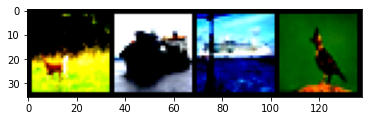

In [5]:
data_iterator = iter(data_loader)
img , label = data_iterator.next()

classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

plt.imshow(utils.make_grid(img).permute(1,2,0))

for i in range(size):
    print(classes[label[i]])

In [6]:
# De todo el dateset tomo dos clases para hacer el modelo,en este caso será binario
classes_name = ['car','cat']
label_map = {1:0,3:1}

data_set = [(img ,label_map[label]) for img ,label in dataset if label in [1,3]]
validation_set = [(img ,label_map[label]) for img ,label in validation_set if label in [1,3]]

Escojo una imagen del dataset 

In [7]:
img , label = data_set[20]
img.shape

torch.Size([3, 32, 32])

# Crear modelo

In [8]:
model = nn.Sequential(
        nn.Linear(3*32*32,512),  #Creao el modelo que es lienal, le paso la función de activación tangente hiperbolica
        nn.Tanh(),       #Luego esas salidas de las neuronas, la vuelvo a pasar a una regresión lineal con salida binaria
        nn.Linear(512,2)
)

El resultado final lo necesito en probabilidad

In [9]:
def softmax(x):
    return torch.exp(x)/torch.exp(x).sum()

In [10]:
x = torch.tensor([1.2,3.5,6.9])
softmax(x),softmax(x).sum()

(tensor([0.0032, 0.0322, 0.9646]), tensor(1.))

La ventaja que me otorga usar soft max es que la suma de las porbabilidades será uno, por lo que lo implementaré en el modelo

In [11]:
model = nn.Sequential(
        nn.Linear(3*32*32,512),  
        nn.Tanh(),       
        nn.Linear(512,2),
        nn.Softmax(dim=1)
    
)

Implemento el modelo

In [12]:
out = model(img.view(-1).unsqueeze(0)) #Modifico el vector de la imagen para que el modelo lo puedo entender
out

tensor([[0.4852, 0.5148]], grad_fn=<SoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


car


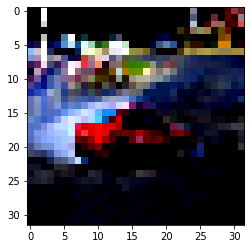

In [13]:
plt.imshow(img.permute(1,2,0))
print(classes_name[label])

In [14]:
_ , index = torch.max(out,dim=1)
print('Esto debería ser un',classes_name[label],'Según el modelo es un',classes_name[index])

Esto debería ser un car Según el modelo es un cat


Como se ve, el modelo tiene un error, para minimizar este error, hay que modificar el modelo

# Modificación del modelo

In [15]:
model = nn.Sequential(
        nn.Linear(3*32*32,512),  
        nn.Tanh(),       
        nn.Linear(512,2),
        nn.LogSoftmax(dim=1)  #Trabajo con logaritmos
    
)

loss_funtion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

n_ephocs = 5 #Número de epocas para el ciclo for

for ephoc in range(n_ephocs):
    for img , label in data_set:
        pred = model(img.view(-1).unsqueeze(0))
        loss = loss_funtion(pred,torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('Epoch: %d, Loss: %f'%(ephoc,float(loss)))

Epoch: 0, Loss: 0.015935
Epoch: 1, Loss: 0.841750
Epoch: 2, Loss: 0.000286
Epoch: 3, Loss: 0.002982


KeyboardInterrupt: 

Esta es una manera de hacerlo, pero es muy costosa en recursos.

In [ ]:
train_loader = torch.utils.data.DataLoader(data_set,batch_size=64,shuffle=True) #Parto el dataset en baches de 64 imágenes

model = nn.Sequential(
        nn.Linear(3*32*32,512),  
        nn.Tanh(),       
        nn.Linear(512,2),
        nn.LogSoftmax(dim=1)  #Trabajo con logaritmos
    
)

loss_funtion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

n_epochs = 100

for epoch in range(n_epochs):
    for img , label in train_loader:
        pred = model(img.view(img.shape[0],-1))   #Cambio la dimension del tensor, al estar en el stack de 64 imagenes las dimensiones las tengo que ajustar
        loss = loss_funtion(pred,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0 :
        print('Epoch: %d, Loss: %f'%(epoch,float(loss)))


# Validación del modelo

In [ ]:
validation_loader = torch.utils.data.DataLoader(validation_set,batch_size=64,shuffle=True)

correct = 0
total   = 0

with torch.no_grad():
    for img , label in validation_loader:
        out = model(img.view(img.shape[0],-1))
        _ , pred = torch.max(out,dim=1)
        
        total   += label.shape[0]
        correct += int((pred == label).sum()) #Comparo los resultados que son iguales, los que sean iguales se marcan como un, y luego se suman 
        
print('Accurancy ==',correct/total)

In [ ]:
img , label = validation_set[25]
out = model(img.view(-1).unsqueeze(0))
_ , pred = torch.max(out,dim=1)

plt.imshow(img.permute(1,2,0))
print('Esto debería ser un',classes_name[label],'Según el modelo es un',classes_name[pred])

# Mejoras al modelo

In [16]:
train_loader = torch.utils.data.DataLoader(data_set,batch_size=64,shuffle=True) #Parto el dataset en baches de 64 imágenes

model = nn.Sequential(
        nn.Linear(3072,1024),  
        nn.Tanh(),     
        nn.Linear(1024,512),  
        nn.Tanh(), 
        nn.Linear(512,128),  
        nn.Tanh(), 
        nn.Linear(128,2)
)

loss_funtion = nn.CrossEntropyLoss() #ESto combina el nn.NLLLoss() y el nn.LogSoftmax() 
optimizer = optim.SGD(model.parameters(),lr=0.01)

n_epochs = 100

for epoch in range(n_epochs):
    for img , label in train_loader:
        pred = model(img.view(img.shape[0],-1))   #Cambio la dimension del tensor, al estar en el stack de 64 imagenes las dimensiones las tengo que ajustar
        loss = loss_funtion(pred,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0 :
        print('Epoch: %d, Loss: %f'%(epoch,float(loss)))

Epoch: 0, Loss: 0.471637
Epoch: 5, Loss: 0.201277
Epoch: 10, Loss: 0.366298
Epoch: 15, Loss: 0.198704
Epoch: 20, Loss: 0.229588
Epoch: 25, Loss: 0.050449
Epoch: 30, Loss: 0.018022
Epoch: 35, Loss: 0.008304
Epoch: 40, Loss: 0.010581
Epoch: 45, Loss: 0.002043
Epoch: 50, Loss: 0.001901
Epoch: 55, Loss: 0.001569
Epoch: 60, Loss: 0.001001
Epoch: 65, Loss: 0.000362
Epoch: 70, Loss: 0.000300
Epoch: 75, Loss: 0.001412
Epoch: 80, Loss: 0.000418
Epoch: 85, Loss: 0.000206
Epoch: 90, Loss: 0.000152
Epoch: 95, Loss: 0.000310


### Validción con el validation_set

In [17]:
validation_loader = torch.utils.data.DataLoader(validation_set,batch_size=64,shuffle=True)

correct = 0
total   = 0

with torch.no_grad():
    for img , label in validation_loader:
        out = model(img.view(img.shape[0],-1))
        _ , pred = torch.max(out,dim=1)
        
        total   += label.shape[0]
        correct += int((pred == label).sum()) #Comparo los resultados que son iguales, los que sean iguales se marcan como un, y luego se suman 
        
print('Accurancy ==',correct/total)

Accurancy == 0.858


### Validción con el data_set

In [18]:
data_loader = torch.utils.data.DataLoader(data_set,batch_size=64,shuffle=True)

correct = 0
total   = 0

with torch.no_grad():
    for img , label in data_loader:
        out = model(img.view(img.shape[0],-1))
        _ , pred = torch.max(out,dim=1)
        
        total   += label.shape[0]
        correct += int((pred == label).sum()) #Comparo los resultados que son iguales, los que sean iguales se marcan como un, y luego se suman 
        
print('Accurancy ==',correct/total)

Accurancy == 1.0


Esto es un problema, ya que le modelo se sobre entrenó , lo cual no es bueno

### Veo el número de parámetros

In [20]:
sum([params.numel() for params in model.parameters() if params.requires_grad == True])

3737474

# Pruebo el modelo con una imagen externa

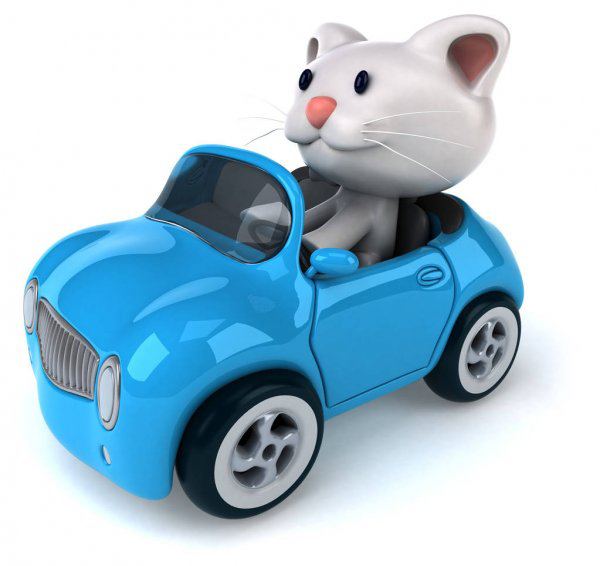

In [26]:
url_e = 'https://st3.depositphotos.com/1036149/13253/i/600/depositphotos_132533272-stock-photo-cat-driving-car.jpg'

image = request.urlretrieve(url_e)
image = Image.open(image[0])

out = model(image.view(-1).unsqueeze(0))
_ , pred = torch.max(out,dim=1)

plt.imshow(img.permute(1,2,0))
print('Esto debería ser un',classes_name[label],'Según el modelo es un',classes_name[pred])

In [27]:
tensor_transform = transforms.ToTensor()
img_tensor = tensor_transform(image)

In [28]:
img_tensor.shape

torch.Size([3, 566, 600])

In [38]:
mean = img_tensor.view(3,-1).mean(dim=1)
std  = img_tensor.view(3,-1).std(dim=1)
mean,std

(tensor([0.6713, 0.7770, 0.8359]), tensor([0.3731, 0.2672, 0.2450]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Según el modelo es un cat


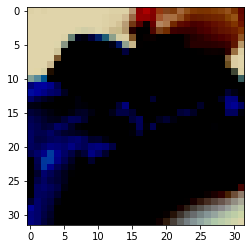

In [74]:
process = transforms.Compose([
    transforms.Resize(48), #Cambio el tamaño de la imagen
    transforms.CenterCrop(32), #Centro la imagen
    transforms.ToTensor(),   #Convierto la imagen un tensor
    transforms.Normalize(
    mean = mean,  
    std  = std)
])

img_t = process(image)

out = model(img_t.view(-1).unsqueeze(0))
_ , pred = torch.max(out,dim=1)

print('Según el modelo es un',classes_name[pred])

plt.imshow(img_t.permute(1,2,0))
plt.show()